# Quick Start: OpenADR 3 Pricing Demo

**Prerequisites:** The VTN must be running in a separate terminal. See `instructions.ipynb` for setup details.

```bash
cd openadr3-vtn-reference-implementation
virtualenv venv && source venv/bin/activate
pip3 install -r requirements.txt
python -m swagger_server
```

## Step 1: Setup & Verify VTN Connection

<img src="presentation/images/step1-auth.svg" width="820"/>

In [4]:
import requests
import json
from datetime import datetime, timedelta
import isodate


In [5]:
# --- Configuration ---
VTN_BASE_URL = "http://localhost:8080/openadr3/3.0.1"
BL_CLIENT_ID = "bl_client"
BL_CLIENT_SECRET = "1001"
VEN_CLIENT_ID = "ven_client"
VEN_CLIENT_SECRET = "999"
OLIVINE_PRICING_URL = 'https://api.olivineinc.com/i/oe/pricing/signal/paced/etou-dyn'


def get_token(client_id, client_secret):
    """Get an OAuth token from the VTN."""
    resp = requests.post(
        f"{VTN_BASE_URL}/auth/token",
        data={
            "grant_type": "client_credentials",
            "client_id": client_id,
            "client_secret": client_secret,
        },
    )
    resp.raise_for_status()
    return resp.json()["access_token"]


def bl_headers():
    """Return Authorization headers for Business Logic role."""
    return {"Authorization": f"Bearer {get_token(BL_CLIENT_ID, BL_CLIENT_SECRET)}"}


def ven_headers():
    """Return Authorization headers for VEN role."""
    return {"Authorization": f"Bearer {get_token(VEN_CLIENT_ID, VEN_CLIENT_SECRET)}"}


# --- Verify VTN is running ---
resp = requests.get(f"{VTN_BASE_URL}/programs", headers=bl_headers())
resp.raise_for_status()
print(f"VTN is running. Current programs: {resp.json()}")

VTN is running. Current programs: []


## Step 2: Fetch Live Prices from Olivine API

<img src="presentation/images/step2-fetch-prices.svg" width="820"/>

In [6]:
# Fetch live pricing data from the Olivine API
olivine_resp = requests.get(OLIVINE_PRICING_URL, headers={'Accept': 'application/json'})
olivine_resp.raise_for_status()
olivine_data = olivine_resp.json()

# Extract metadata from vtnComment
vtn_comment = olivine_data["eventDescriptor"]["vtnComment"]
metadata = dict(item.split(':', 1) for item in vtn_comment.split(';'))
print("Metadata:")
for key, value in metadata.items():
    print(f"  {key}: {value}")

# Extract start time using isodate
start_time_str = olivine_data["eiActivePeriod"]["properties"]["dtstart"]["datetime"]["value"]
start_time = isodate.parse_datetime(start_time_str)

# Extract price intervals
intervals = olivine_data["eiEventSignals"]["eiEventSignal"][0]["intervals"]

print(f"\nPricing window start: {start_time}")
print(f"Number of hourly intervals: {len(intervals)}")
print(f"\nHourly prices (USD/kWh):")

current_time = start_time
for interval_data in intervals:
    interval_num = int(interval_data["item"]["text"])
    price = interval_data["streamPayloadBase"][0]["item"]["value"]
    duration_str = interval_data["duration"]["duration"]
    
    # Parse duration and calculate end time
    duration = isodate.parse_duration(duration_str)
    end_time = current_time + duration
    
    print(f"  Hour {interval_num:2d}: ${price:.5f} ({current_time:%Y-%m-%d %H:%M} to {end_time:%Y-%m-%d %H:%M})")
    
    current_time = end_time

Metadata:
  BindingPrices: True
  LocalPrice: False
  RetailerLong: Pacific Utility Company
  RateNameLong: E-TOU Dynamic
  DateAnnounced: 2020-01-01
  DateStart: 2020-06-01
  URL: http://www.example.org/PUC/paced-etou-dyn

Pricing window start: 2026-02-19 05:00:00+00:00
Number of hourly intervals: 24

Hourly prices (USD/kWh):
  Hour  0: $0.12266 (2026-02-19 05:00 to 2026-02-19 06:00)
  Hour  1: $0.12150 (2026-02-19 06:00 to 2026-02-19 07:00)
  Hour  2: $0.11990 (2026-02-19 07:00 to 2026-02-19 08:00)
  Hour  3: $0.11809 (2026-02-19 08:00 to 2026-02-19 09:00)
  Hour  4: $0.12066 (2026-02-19 09:00 to 2026-02-19 10:00)
  Hour  5: $0.11821 (2026-02-19 10:00 to 2026-02-19 11:00)
  Hour  6: $0.11780 (2026-02-19 11:00 to 2026-02-19 12:00)
  Hour  7: $0.11823 (2026-02-19 12:00 to 2026-02-19 13:00)
  Hour  8: $0.12151 (2026-02-19 13:00 to 2026-02-19 14:00)
  Hour  9: $0.12692 (2026-02-19 14:00 to 2026-02-19 15:00)
  Hour 10: $0.12514 (2026-02-19 15:00 to 2026-02-19 16:00)
  Hour 11: $0.12257 (2

In [7]:
intervals

[{'duration': {'duration': 'PT1H'},
  'item': {'text': '0'},
  'streamPayloadBase': [{'item': {'value': 0.12265545}}]},
 {'duration': {'duration': 'PT1H'},
  'item': {'text': '1'},
  'streamPayloadBase': [{'item': {'value': 0.12150466}}]},
 {'duration': {'duration': 'PT1H'},
  'item': {'text': '2'},
  'streamPayloadBase': [{'item': {'value': 0.11990022}}]},
 {'duration': {'duration': 'PT1H'},
  'item': {'text': '3'},
  'streamPayloadBase': [{'item': {'value': 0.11809197}}]},
 {'duration': {'duration': 'PT1H'},
  'item': {'text': '4'},
  'streamPayloadBase': [{'item': {'value': 0.12066241}}]},
 {'duration': {'duration': 'PT1H'},
  'item': {'text': '5'},
  'streamPayloadBase': [{'item': {'value': 0.11820811}}]},
 {'duration': {'duration': 'PT1H'},
  'item': {'text': '6'},
  'streamPayloadBase': [{'item': {'value': 0.11779816}}]},
 {'duration': {'duration': 'PT1H'},
  'item': {'text': '7'},
  'streamPayloadBase': [{'item': {'value': 0.11822945}}]},
 {'duration': {'duration': 'PT1H'},
  'i

## Step 3: Create a Pricing Program on the VTN

<img src="presentation/images/step3-create-program.svg" width="820"/>

In [8]:
# Create a pricing program on the VTN
program_data = {
    "programName": "etou-dynamic-pricing",
    "programLongName": "Dynamic Time-of-Use Pricing (eTOU-Dyn)",
    "programType": "PRICING",
    "retailerName": "PUC",
    "retailerLongName": "Pacific Utility Company",
    "country": "US",
    "principalSubdivision": "CA",
    "payloadDescriptors": [
        {
            "objectType": "EVENT_PAYLOAD_DESCRIPTOR",
            "payloadType": "PRICE",
            "units": "KWH",
            "currency": "USD"
        }
    ]
}

resp = requests.post(
    f"{VTN_BASE_URL}/programs",
    json=program_data,
    headers=bl_headers(),
)
print(f"Status: {resp.status_code}")
resp.raise_for_status()
program = resp.json()
program_id = program["id"]
print(f"Program created!  ID: {program_id}")
print(json.dumps(program, indent=2))

Status: 201
Program created!  ID: 0
{
  "createdDateTime": "2026-02-18 21:40:18",
  "id": "0",
  "objectType": "PROGRAM",
  "programName": "etou-dynamic-pricing"
}


## Step 4: Publish Price Signal as an Event

Convert the Olivine pricing data into an OpenADR 3 event and publish it to the VTN.

<img src="presentation/images/step4-publish-event.svg" width="820"/>

In [9]:
# Convert Olivine pricing data to an OpenADR 3 event
event_data = {
    "eventName": f"etou-dyn-{olivine_data['eventDescriptor']['eventID']}",
    "programID": program_id,
    "intervalPeriod": {
        "start": start_time.isoformat(),
        "duration": "PT1H"
    },
    "payloadDescriptors": [
        {
            "objectType": "EVENT_PAYLOAD_DESCRIPTOR",
            "payloadType": "PRICE",
            "units": "KWH",
            "currency": "USD"
        }
    ],
    "intervals": [
        {
            "id": int(interval_data["item"]["text"]),
            "payloads": [{"type": "PRICE", "values": [round(interval_data["streamPayloadBase"][0]["item"]["value"], 5)]}]
        }
        for interval_data in intervals
    ]
}

resp = requests.post(
    f"{VTN_BASE_URL}/events",
    json=event_data,
    headers=bl_headers(),
)
print(f"Status: {resp.status_code}")
resp.raise_for_status()
event = resp.json()
print(f"Event created!  ID: {event['id']}")
print(f"Intervals published: {len(event['intervals'])}")
print(json.dumps(event, indent=2))

Status: 201
Event created!  ID: 0
Intervals published: 24
{
  "createdDateTime": "2026-02-18 21:40:22",
  "eventName": "etou-dyn-PUC-paced-etou-dyn-2026-02-18",
  "id": "0",
  "intervalPeriod": {
    "duration": "PT1H",
    "start": "2026-02-19T05:00:00+00:00"
  },
  "intervals": [
    {
      "id": 0,
      "payloads": [
        {
          "type": "PRICE",
          "values": [
            0.12266
          ]
        }
      ]
    },
    {
      "id": 1,
      "payloads": [
        {
          "type": "PRICE",
          "values": [
            0.1215
          ]
        }
      ]
    },
    {
      "id": 2,
      "payloads": [
        {
          "type": "PRICE",
          "values": [
            0.1199
          ]
        }
      ]
    },
    {
      "id": 3,
      "payloads": [
        {
          "type": "PRICE",
          "values": [
            0.11809
          ]
        }
      ]
    },
    {
      "id": 4,
      "payloads": [
        {
          "type": "PRICE",
          "va

## Step 5: Read Events as a VEN

Authenticate as a VEN client and read the pricing events from the VTN — this is what a water heater controller would do.

<img src="presentation/images/step5-read-ven.svg" width="820"/>

In [10]:
# Read all events as a VEN
resp = requests.get(f"{VTN_BASE_URL}/events", headers=ven_headers())
resp.raise_for_status()
events = resp.json()

print(f"Number of events: {len(events)}")
for evt in events:
    print(f"\n--- Event: {evt.get('eventName', evt['id'])} ---")
    print(f"  Program ID: {evt['programID']}")
    print(f"  Start: {evt.get('intervalPeriod', {}).get('start', 'N/A')}")
    print(f"  Intervals: {len(evt['intervals'])}")
    print(f"  Prices (USD/kWh):")
    for interval in sorted(evt["intervals"], key=lambda x: x["id"]):
        for payload in interval["payloads"]:
            if payload["type"] == "PRICE":
                print(f"    Hour {interval['id']:2d}: ${payload['values'][0]:.5f}")

Number of events: 1

--- Event: etou-dyn-PUC-paced-etou-dyn-2026-02-18 ---
  Program ID: 0
  Start: 2026-02-19T05:00:00+00:00
  Intervals: 24
  Prices (USD/kWh):
    Hour  0: $0.12266
    Hour  1: $0.12150
    Hour  2: $0.11990
    Hour  3: $0.11809
    Hour  4: $0.12066
    Hour  5: $0.11821
    Hour  6: $0.11780
    Hour  7: $0.11823
    Hour  8: $0.12151
    Hour  9: $0.12692
    Hour 10: $0.12514
    Hour 11: $0.12257
    Hour 12: $0.12292
    Hour 13: $0.12003
    Hour 14: $0.11663
    Hour 15: $0.11496
    Hour 16: $0.11353
    Hour 17: $0.11191
    Hour 18: $0.10918
    Hour 19: $0.11637
    Hour 20: $0.12448
    Hour 21: $0.12548
    Hour 22: $0.12511
    Hour 23: $0.12492


## Step 6: Run LP Scheduler

Use the LP scheduler to convert the price signals from the VTN into a globally optimal heat pump water heater operation schedule. The linear program minimises total electricity cost subject to storage capacity and HP bounds.

**Parameters below are for a typical residential heat pump water heater (HPWH):**
- 80-gallon tank (~12 kWh thermal capacity)
- 4.5 kW heat pump output
- COP ~3.0 (constant for simplicity; replace with hourly COP array for higher accuracy)
- Assumed uniform hot water draw profile across the pricing window

*Swap `hpwh_load_shift_lp` for `hpwh_load_shift_heuristic` to use the greedy alternative (no scipy required).*

<img src="presentation/images/step6-lp-scheduler.svg" width="820"/>

Horizon: 24 hours
Prices ($/kWh): [0.12266, 0.1215, 0.1199, 0.11809, 0.12066, 0.11821, 0.1178, 0.11823, 0.12151, 0.12692, 0.12514, 0.12257, 0.12292, 0.12003, 0.11663, 0.11496, 0.11353, 0.11191, 0.10918, 0.11637, 0.12448, 0.12548, 0.12511, 0.12492]
LP status: 0 — Optimization terminated successfully. (HiGHS Status 7: Optimal)

Converged: True

Hourly schedule (kWh):
  Hour  0: OFF   0.00 kWh  @ $0.12266/kWh  cost=$0.00000
  Hour  1: OFF   0.00 kWh  @ $0.12150/kWh  cost=$0.00000
  Hour  2: OFF   0.00 kWh  @ $0.11990/kWh  cost=$0.00000
  Hour  3: ON    4.50 kWh  @ $0.11809/kWh  cost=$0.17714
  Hour  4: OFF   0.00 kWh  @ $0.12066/kWh  cost=$0.00000
  Hour  5: ON    4.50 kWh  @ $0.11821/kWh  cost=$0.17732
  Hour  6: ON    4.50 kWh  @ $0.11780/kWh  cost=$0.17670
  Hour  7: ON    2.50 kWh  @ $0.11823/kWh  cost=$0.09853
  Hour  8: OFF   0.00 kWh  @ $0.12151/kWh  cost=$0.00000
  Hour  9: OFF   0.00 kWh  @ $0.12692/kWh  cost=$0.00000
  Hour 10: OFF   0.00 kWh  @ $0.12514/kWh  cost=$0.00000
  Hou

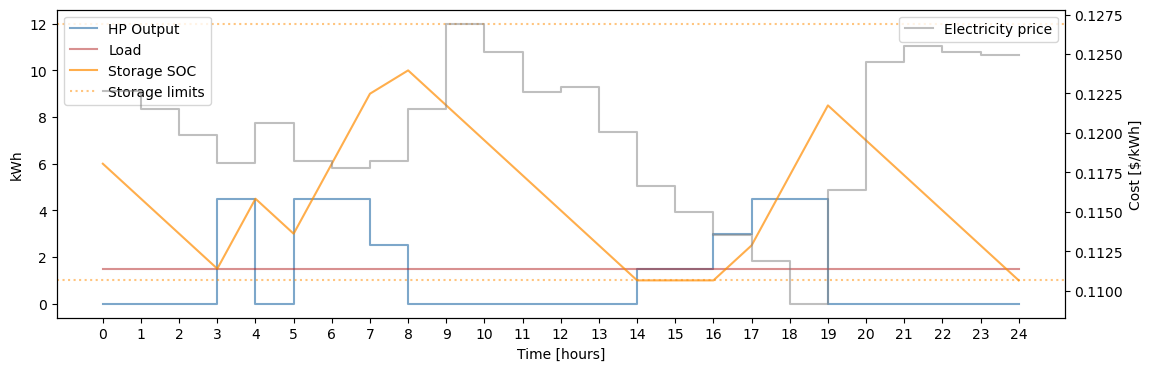

In [18]:
from controls.hpwh_load_shift_lp import hpwh_load_shift, simulate_soc, iteration_plot
# Swap the import below to use the greedy heuristic instead:
# from controls.hpwh_load_shift_heuristic import hpwh_load_shift, simulate_soc, iteration_plot

# --- Extract prices from the VEN event (Step 5) ---
evt = events[0]
prices = []
for interval in sorted(evt["intervals"], key=lambda x: x["id"]):
    for payload in interval["payloads"]:
        if payload["type"] == "PRICE":
            prices.append(payload["values"][0])

horizon = len(prices)
print(f"Horizon: {horizon} hours")
print(f"Prices ($/kWh): {prices}")

# --- HPWH parameters ---
max_hp_output = 4.5      # kW (heat pump max thermal output)
min_hp_output = 0.0      # kW (fully variable speed)
max_storage   = 12.0     # kWh (80-gal tank thermal capacity)
min_storage   = 1.0      # kWh (keep small reserve)
initial_soc   = 6.0      # kWh (start half full)
cop           = 3.0      # constant COP for simplicity
avg_draw      = 1.5      # kWh per hour (typical residential draw)

params = {
    "n":                      horizon,
    "price":                  prices,
    "load":                   [avg_draw] * horizon,
    "cop":                    [cop] * horizon,
    "initial_soc":            initial_soc,
    "min_storage_capacity":   min_storage,
    "max_storage_capacity":   max_storage,
    "min_input":              min_hp_output,
    "max_input":              max_hp_output,
}

# --- Run LP Scheduler ---
schedule, converged = hpwh_load_shift(params, verbose=True)

print(f"\nConverged: {converged}")
print(f"\nHourly schedule (kWh):")
for i in range(horizon):
    on_off = "ON " if schedule["control"][i] > 0.01 else "OFF"
    print(f"  Hour {i:2d}: {on_off}  {schedule['control'][i]:5.2f} kWh  @ ${prices[i]:.5f}/kWh  cost=${schedule['cost'][i]:.5f}")

print(f"\nTotal electricity cost: ${sum(schedule['cost']):.5f}")

# --- Plot ---
iteration_plot(schedule, params)

## Step 7: Generate CTA-2045 Schedule

Convert the LP Scheduler output into CTA-2045-B demand response commands for the water heater. CTA-2045 is a modular communications interface standard that translates high-level signals into device-level actions:

| Signal | Code | Water Heater Action |
|---|---|---|
| **Shed** | -1 | Lower setpoint, disable heat pump — coast on stored energy |
| **Normal** | 0 | Default operation |
| **Load Up** | 1 | Raise setpoint, pre-heat the tank |
| **Advanced Load Up** | 2 | Aggressively heat tank (max setpoint, tight deadband) |

The mapping is based on the heat pump output level relative to its maximum capacity.

<img src="presentation/images/step7-cta2045.svg" width="820"/>

CTA-2045 Demand Response Schedule
Hour  Signal  Command                  Price   HP Output
------------------------------------------------------------
   0    -1  Shed                $  0.12266      0.00 kWh
   1    -1  Shed                $  0.12150      0.00 kWh
   2    -1  Shed                $  0.11990      0.00 kWh
   3     2  Advanced Load Up    $  0.11809      4.50 kWh
   4    -1  Shed                $  0.12066      0.00 kWh
   5     2  Advanced Load Up    $  0.11821      4.50 kWh
   6     2  Advanced Load Up    $  0.11780      4.50 kWh
   7     1  Load Up             $  0.11823      2.50 kWh
   8    -1  Shed                $  0.12151      0.00 kWh
   9    -1  Shed                $  0.12692      0.00 kWh
  10    -1  Shed                $  0.12514      0.00 kWh
  11    -1  Shed                $  0.12257      0.00 kWh
  12    -1  Shed                $  0.12292      0.00 kWh
  13    -1  Shed                $  0.12003      0.00 kWh
  14     1  Load Up             $  0.11663      1.

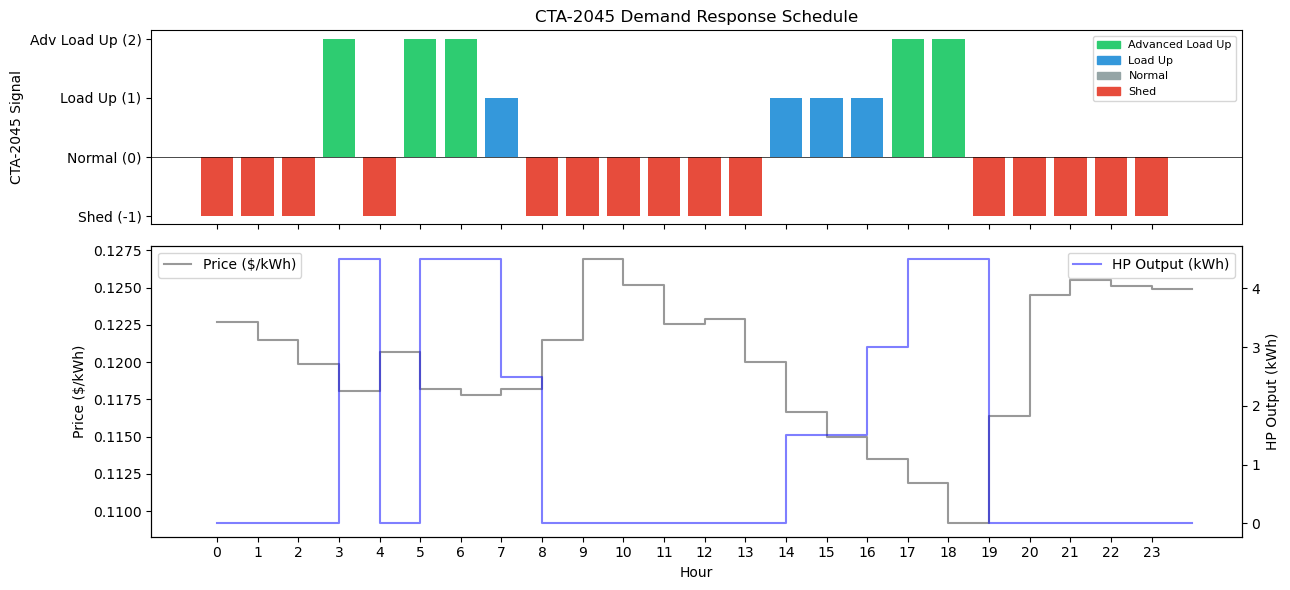

In [12]:
from controls import hpwh_load_shift_to_cta2045, format_schedule, plot_schedule

# --- Convert LP Scheduler output to CTA-2045 commands ---
cta_schedule = hpwh_load_shift_to_cta2045(schedule, params)

# --- Print the schedule ---
print("CTA-2045 Demand Response Schedule")
print("=" * 60)
print(format_schedule(cta_schedule))

print(f"\nSignal summary:")
from collections import Counter
counts = Counter(cta_schedule['signal_names'])
for name, count in sorted(counts.items()):
    print(f"  {name}: {count} hours")

# --- Plot ---
plot_schedule(cta_schedule)